In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from peft import PeftModel, PeftConfig
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer

## Load HealthStory Dataset

In [ ]:
index = []  # News ID (file name)
X = []  # Article text

path = '/content/drive/MyDrive/Medical_Misinformation_Team/data/FakeHealth-master/dataset/content/HealthStory'
for file_name in os.listdir(path):
    with open(os.path.join(path, file_name), 'r') as f:
        # Load data
        data = json.load(f)

        # Add news ID to index list
        news_id = file_name.split('.')[0]
        index.append(news_id)

        # Add article text to X list
        X.append(data['text'])
X = pd.DataFrame(X, index=index, columns=['text'])

In [ ]:
path = '/content/drive/MyDrive/Medical_Misinformation_Team/data/FakeHealth-master/dataset/reviews/HealthStory.json'
with open(path, 'r') as f:
    data = json.load(f)
    y = [{'news_id': item['news_id'], 'rating': item['rating']} for item in data]
y = pd.DataFrame(y)
y = y.set_index('news_id')
y.index.name = None

In [ ]:
Xy = X.join(y, how='outer')
Xy

,text,rating
story_reviews_00000,Scientists have found an unexpected use for vi...,1
story_reviews_00001,(Reuters) - Evofem Biosciences Inc said on Mon...,3
story_reviews_00002,A Chicago couple who previously suffered two m...,2
story_reviews_00003,"(Reuters) - Johnson & Johnson said its drug, T...",2
story_reviews_00004,En Español\n\nBy Steven Reinberg\n\nHealthDay ...,5
...,...,...
story_reviews_01694,CHICAGO (Reuters) - Radiation from CT scans do...,3
story_reviews_01695,A butterfly approaches a teacup in Rome May 13...,4
story_reviews_01697,"Dec. 14, 2009 -- A less invasive needle biopsy...",2
story_reviews_01698,"(CNN) -- As a thick, gray haze began to descen...",2


In [ ]:
Xy.dropna(inplace=True)

In [ ]:
Xy

,text,rating
story_reviews_00000,Scientists have found an unexpected use for vi...,1
story_reviews_00001,(Reuters) - Evofem Biosciences Inc said on Mon...,3
story_reviews_00002,A Chicago couple who previously suffered two m...,2
story_reviews_00003,"(Reuters) - Johnson & Johnson said its drug, T...",2
story_reviews_00004,En Español\n\nBy Steven Reinberg\n\nHealthDay ...,5
...,...,...
story_reviews_01694,CHICAGO (Reuters) - Radiation from CT scans do...,3
story_reviews_01695,A butterfly approaches a teacup in Rome May 13...,4
story_reviews_01697,"Dec. 14, 2009 -- A less invasive needle biopsy...",2
story_reviews_01698,"(CNN) -- As a thick, gray haze began to descen...",2


In [ ]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, ratings, tokenizer, max_length=512, stride=512):
        self.examples = []
        # self.ratings = []
        # self.id = []
        for id, (text, rating) in enumerate(zip(texts, ratings)):
            # Tokenize the full text without truncation
            tokenized = tokenizer(
                text,
                return_attention_mask=False,
                return_token_type_ids=False,
                add_special_tokens=True
            )
            input_ids = tokenized['input_ids']

            # Split input_ids into chunks
            for i in range(0, len(input_ids), stride):
                chunk = input_ids[i:i + max_length]
                if len(chunk) == 0:
                    continue
                # self.id.append(id)
                # Pad if necessary
                if len(chunk) < max_length:
                    chunk += [tokenizer.pad_token_id] * (max_length - len(chunk))
                self.examples.append({'input_ids': chunk, 'rating': rating, 'id': id})
                assert len(chunk) == max_length
                # self.ratings.append(rating)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return {key: torch.tensor(val) for key, val in self.examples[idx].items()}


## Inference/Plotting Function

In [ ]:
def create_boxplot(model, tokenizer, filename):
  dataset = TextDataset(Xy["text"].tolist(), Xy['rating'].tolist(), tokenizer)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')
  dataloader = DataLoader(dataset, batch_size=32, collate_fn=lambda batch: data_collator([{
      k: v.squeeze(0) for k, v in item.items()
  } for item in batch]))

  # Move to CUDA if available
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  all_preds = []
  all_ratings = []
  all_ids = []
  for batch in dataloader:
      input_data = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
      batch = {k: v for k, v in batch.items() if k in ['rating', 'id']}
      with torch.no_grad():
          ratings = batch['rating'].cpu().numpy()
          ids = batch['id'].cpu().numpy()
          outputs = model(**input_data)
          preds = torch.softmax(outputs.logits, dim=-1)
          all_preds.extend(preds.cpu().numpy())
          all_ratings.extend(ratings)
          all_ids.extend(ids)

  all_preds = np.array(all_preds)
  all_ratings = np.array(all_ratings)

  df = pd.DataFrame({'rating': all_ratings, 'output': all_preds[:, 0], 'id': all_ids})
  pred_means = df.groupby('id')['output'].mean().values
  agg_ratings = df.groupby('id')['rating'].first().values

  # Group continuous values by discrete values
  grouped_data = [pred_means[agg_ratings == i] for i in range(6)]

  # Create box plot
  plt.boxplot(grouped_data, positions=range(6))
  plt.xlabel('Rating')
  plt.ylabel('Model Output')
  plt.title('Output Distribution by Rating')
  plt.xticks(range(6))  # Set x-ticks to match discrete values
  plt.grid(True)
  # plt.show()
  plt.savefig(filename)

## Base Model (`bert-base-uncased`)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


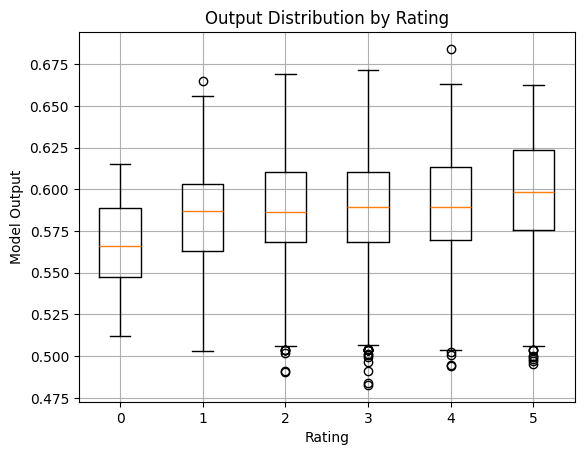

In [ ]:
create_boxplot(model, tokenizer, 'base_model_boxplot.png')

## LoRA Checkpoint Model

In [ ]:
# Define LoRA paths
lora_tokenizer_path = '/content/drive/MyDrive/Medical_Misinformation_Team/models/verifier/lora-checkpoint'
lora_adapter_path = '/content/drive/MyDrive/Medical_Misinformation_Team/models/verifier/lora-checkpoint'

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(lora_tokenizer_path)

# Load PEFT config
peft_config = PeftConfig.from_pretrained(lora_adapter_path)

# Load base model (from hub or your own saved path)
base_model = AutoModelForSequenceClassification.from_pretrained(peft_config.base_model_name_or_path, num_labels=2)

# Load the LoRA adapter onto the base model
model = PeftModel.from_pretrained(base_model, lora_adapter_path)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModel(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


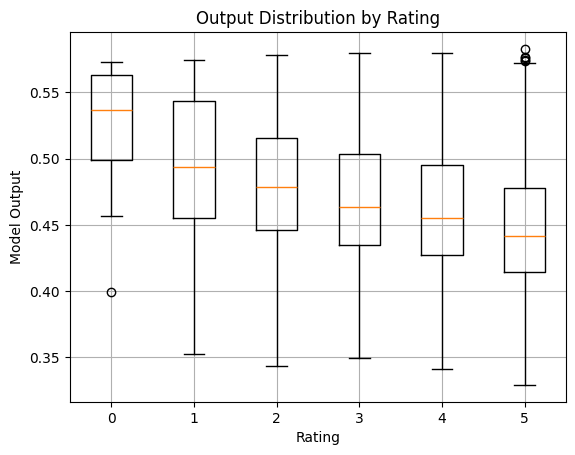

In [ ]:
create_boxplot(model, tokenizer, 'lora_checkpoint_boxplot.png')

## Final Checkpoint Model

In [ ]:
# Define LoRA paths
lora_tokenizer_path = '/content/drive/MyDrive/Medical_Misinformation_Team/models/verifier/final-checkpoint'
lora_adapter_path = '/content/drive/MyDrive/Medical_Misinformation_Team/models/verifier/final-checkpoint'

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(lora_tokenizer_path)

# Load PEFT config
peft_config = PeftConfig.from_pretrained(lora_adapter_path)

# Load base model (from hub or your own saved path)
base_model = AutoModelForSequenceClassification.from_pretrained(peft_config.base_model_name_or_path, num_labels=2)

# Load the LoRA adapter onto the base model
model = PeftModel.from_pretrained(base_model, lora_adapter_path)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModel(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


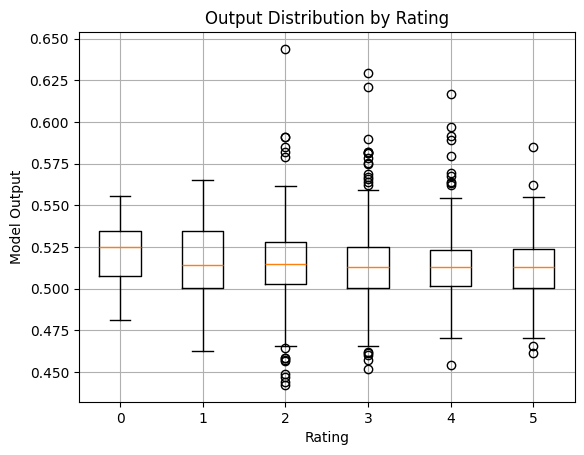

In [ ]:
create_boxplot(model, tokenizer, 'final_checkpoint_boxplot.png')